In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
import statsmodels.formula.api as smf
import numpy as np
from scipy.special import logit, expit
%matplotlib inline

In [2]:
sentiment = pd.read_csv('consumer_sentiment.csv')

In [3]:
sentiment

CASEID  YYYYMM  YYYYQ  YYYY    ID IDPREV  DATEPR     ICS     ICC  \
0            1  197801  19781  1978     1                  76.71  116.23   
1            2  197801  19781  1978     2                 121.12  154.08   
2            3  197801  19781  1978     3                   2.70    2.70   
3            4  197801  19781  1978     4                  76.71  154.08   
4            5  197801  19781  1978     5                 121.12  116.23   
...        ...     ...    ...   ...   ...    ...     ...     ...     ...   
312726  312727  202307  20233  2023  2097   1130  202301   31.60   39.84   
312727  312728  202307  20233  2023  2098   1038  202301   76.01  153.38   
312728  312729  202307  20233  2023  2099   1141  202301   61.21  115.53   
312729  312730  202307  20233  2023  2100   1071  202301   90.81   77.69   
312730  312731  202307  20233  2023  2101   1080  202301  120.42  153.38   

           ICE  
0        51.32  
1        99.94  
2         2.70  
3        27.01  
4       124.25  
...        ...  
312726   26.31  
312727   26.31  
312728   26.31  
312729   99.24  
312730   99.24  

[312731 rows x 10 columns]

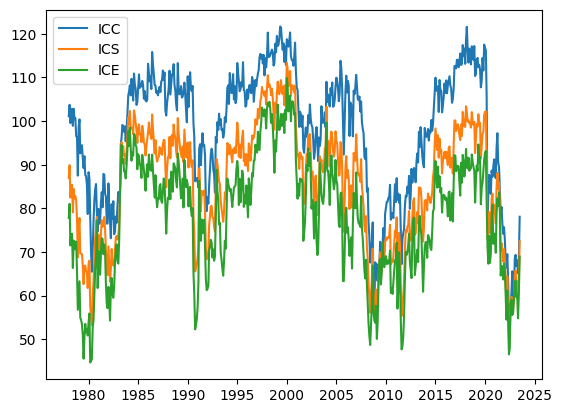

In [4]:
sentiment['DATE'] = pd.to_datetime(sentiment.YYYYMM, format="%Y%m")

sentiment_by_month = sentiment.groupby(['DATE'])[['ICC','ICS','ICE']].mean()

plt.plot(sentiment_by_month.ICC)
plt.plot(sentiment_by_month.ICS)
plt.plot(sentiment_by_month.ICE)
plt.legend(["ICC", "ICS", "ICE"])
plt.show()

In [62]:
sentiment_by_month.describe()

ICC         ICS         ICE
count  547.000000  547.000000  547.000000
mean    97.895492   85.993063   78.345096
std     14.598126   13.455466   13.566450
min     53.548571   49.282608   44.683748
25%     87.424618   75.245689   68.378410
50%    101.969485   89.598520   80.764400
75%    108.471766   95.848786   88.520986
max    121.664360  113.337352  109.857609

In [61]:
sentiment_by_month.corr()

ICC       ICS       ICE
ICC  1.000000  0.946378  0.850341
ICS  0.946378  1.000000  0.974749
ICE  0.850341  0.974749  1.000000

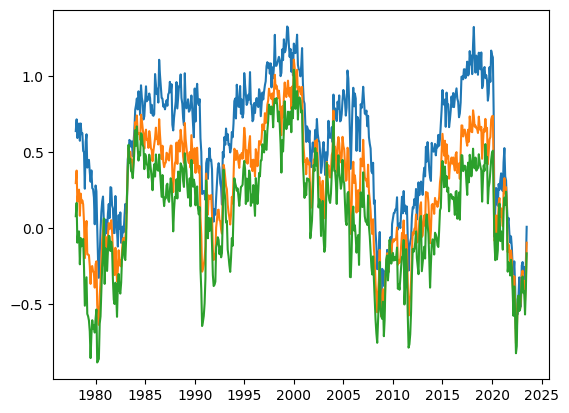

In [107]:
plt.plot(logit((sentiment_by_month.ICC - 2) * 2.6424  / 2 / 100 / 2))
plt.plot(logit((sentiment_by_month.ICS - 2) * 6.7558  / 5 / 100 / 2))
plt.plot(logit((sentiment_by_month.ICE - 2) * 4.1134  / 3 / 100 / 2))


In [110]:
survey_logits = pd.DataFrame({'sentiment': logit((sentiment_by_month.ICS - 2) * 6.7558  / 5 / 100 / 2),
                              'current': logit((sentiment_by_month.ICC - 2) * 2.6424  / 2 / 100 / 2),
                              'expectations': logit((sentiment_by_month.ICE - 2) * 4.1134  / 3 / 100 / 2)})

In [113]:
(sentiment_by_month/200).describe()

ICC         ICS         ICE
count  547.000000  547.000000  547.000000
mean     0.489477    0.429965    0.391725
std      0.072991    0.067277    0.067832
min      0.267743    0.246413    0.223419
25%      0.437123    0.376228    0.341892
50%      0.509847    0.447993    0.403822
75%      0.542359    0.479244    0.442605
max      0.608322    0.566687    0.549288

In [112]:
survey_logits.describe()

sentiment     current  expectations
count  547.000000  547.000000    547.000000
mean     0.279365    0.566922      0.095910
std      0.377139    0.416171      0.383314
min     -0.756384   -0.660934     -0.882666
25%     -0.020668    0.258693     -0.180213
50%      0.371404    0.665070      0.160272
75%      0.549517    0.863314      0.377040
max      1.110235    1.327959      1.043038

In [5]:
unemployment = pd.read_csv("unemployment_rate.csv")
unemployment['DATE'] = pd.to_datetime(unemployment.DATE)
unemployment = unemployment.set_index('DATE')
inflation = pd.read_csv("inflation.csv")
inflation['DATE'] = pd.to_datetime(inflation.DATE)
inflation = inflation.set_index('DATE')
interest_rates = pd.read_csv("interest_rates.csv")
interest_rates['DATE'] = pd.to_datetime(interest_rates['DATE'])
interest_rates = interest_rates.set_index('DATE')

In [280]:
data = pd.DataFrame(data={"sentiment": sentiment_by_month.ICS,
                          "current": sentiment_by_month.ICC,
                          "future": sentiment_by_month.ICE,
                          "sentiment_logit": survey_logits.sentiment,
                          "inflation": inflation.CORESTICKM159SFRBATL, 
                          "unemployment": unemployment.UNRATE,
                          "rates": interest_rates.DFF}).dropna()

gdp = pd.read_csv('gdp.csv')
gdp['DATE'] = pd.to_datetime(gdp.DATE)
gdp = gdp.set_index('DATE')
gdp_growth = gdp.pct_change()
data['gdp_growth'] = gdp_growth.GDPC1
data = data.fillna(method="pad")

dj = pd.read_csv('dowjones.csv')
dj['DATE'] = pd.to_datetime(dj.Date, format="%m/%d/%y")
dj = dj.set_index('DATE')
dj.columns = [c.strip() for c in dj.columns]
di = pd.DataFrame(data.index).set_index('DATE')
dj = dj.join(di, how='outer').fillna(method="pad").join(di, how='right').dropna()
data['dow_change'] = dj.Close.pct_change()

data = data.dropna()

In [8]:
def norm(series):
    return (series-series.mean())/series.std()

In [9]:
plt.plot(norm(data.sentiment))
plt.plot(norm(data.unemployment))
plt.plot(norm(data.inflation))
plt.plot(norm(data.rates))
plt.plot(norm(data.gdp_growth))
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates', 'gdp growth'])
plt.show()

In [141]:
def try_model(data, form, predicted=data.sentiment, y_min=50, y_max=150, neutral=100):
    fig,axis = plt.subplots()
    data_precovid = data[data.index < '2020-02-01']
    model_80s = smf.ols(formula=form, data=data, subset=data.index < '1990').fit()
    model_precovid = smf.ols(formula=form, data=data, subset=data.index < '2020-02-01').fit()
    model_full = smf.ols(formula=form, data=data).fit()
    axis.plot(predicted)
    for name, model in zip(["80s", "Pre-Covid", "Full"], [model_80s, model_precovid, model_full]):
        print(f"Model {name}")
        print(model.summary())
        plt.plot(model.predict(data))
    axis.axhline(y = neutral, color='lightgrey')
    axis.legend(['sentiment', '80s', 'pre-covid', 'full', 'neutral'])
    plt.title(f"Models")
    axis.set_ylim(y_min, y_max)
    plt.show()
    return model_full

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     255.4
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.34e-47
Time:                        17:17:01   Log-Likelihood:                -462.62
No. Observations:                 144   AIC:                             931.2
Df Residuals:                     141   BIC:                             940.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      123.7417      2.782    

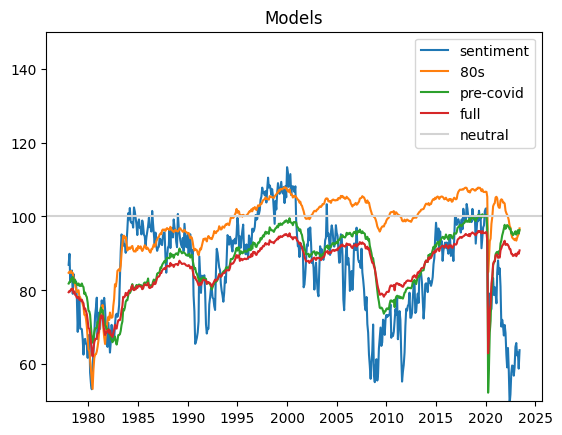

In [142]:
try_model(data, "sentiment ~ inflation + unemployment")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     170.0
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.78e-46
Time:                        09:47:00   Log-Likelihood:                -462.29
No. Observations:                 144   AIC:                             932.6
Df Residuals:                     140   BIC:                             944.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      123.6508      2.788    

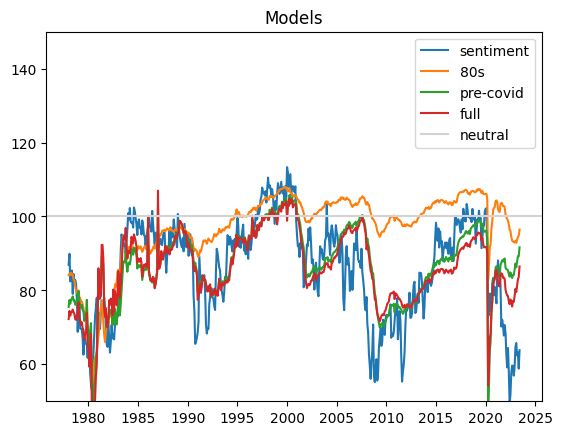

In [12]:
try_model(data, "sentiment ~ inflation + unemployment + rates")

In [13]:
plt.plot(norm(data.sentiment))
plt.plot(norm(data.unemployment.rolling(24).mean()))
plt.plot(norm(data.inflation.rolling(24).mean()))
plt.plot(norm(data.rates.rolling(24).mean()))
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.title("24 month rolling average")
plt.show()

In [14]:
data['unemployment_12_month'] = data.unemployment.rolling(12).mean()
data['inflation_12_month'] = data.inflation.rolling(12).mean()
data['rates_12_month'] = data.rates.rolling(12).mean()
data['gdp_growth_12_month'] = data.gdp_growth.rolling(12).mean()

In [15]:
try_model(data, "sentiment ~ inflation + unemployment + rates + unemployment_12_month + inflation_12_month + rates_12_month")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     99.73
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.99e-45
Time:                        09:47:01   Log-Likelihood:                -417.64
No. Observations:                 133   AIC:                             849.3
Df Residuals:                     126   BIC:                             869.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     83.15
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           3.88e-46
Time:                        09:47:01   Log-Likelihood:                -410.88
No. Observations:                 133   AIC:                             839.8
Df Residuals:                     124   BIC:                             865.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

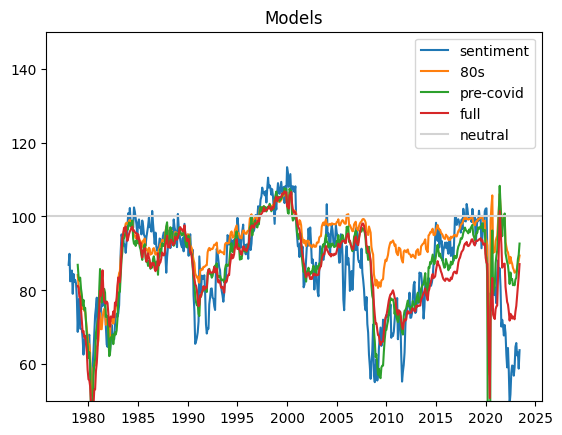

In [16]:
try_model(data, "sentiment ~ inflation + unemployment + rates + gdp_growth + unemployment_12_month + inflation_12_month + rates_12_month + gdp_growth_12_month")

In [17]:
data['unemployment_24_month'] = data.unemployment.rolling(24).mean()
data['inflation_24_month'] = data.inflation.rolling(24).mean()
data['rates_24_month'] = data.rates.rolling(24).mean()
data['gdp_growth_24_month'] = data.rates.rolling(24).mean()
try_model(data, "sentiment ~ inflation + unemployment + rates + unemployment_24_month + inflation_24_month + rates_24_month")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     133.0
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           4.43e-49
Time:                        09:47:02   Log-Likelihood:                -355.42
No. Observations:                 121   AIC:                             724.8
Df Residuals:                     114   BIC:                             744.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

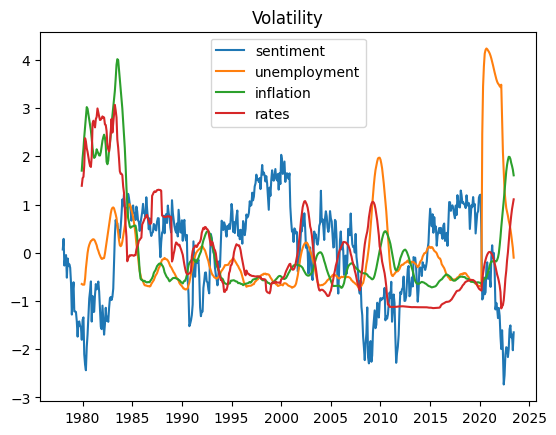

In [18]:
plt.plot(norm(data.sentiment))
plt.plot(norm(data.unemployment.rolling(24).std()))
plt.plot(norm(data.inflation.rolling(24).std()))
plt.plot(norm(data.rates.rolling(24).std()))
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.title("Volatility")
plt.show()

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     105.7
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           3.34e-44
Time:                        09:47:02   Log-Likelihood:                -367.40
No. Observations:                 121   AIC:                             748.8
Df Residuals:                     114   BIC:                             768.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

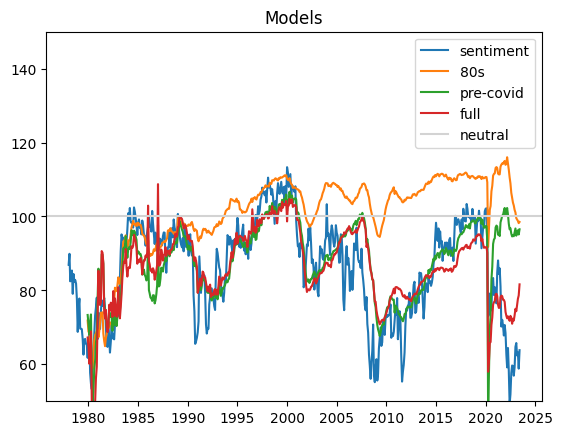

In [19]:
data['unemployment_volatility'] = data.unemployment.rolling(24).std()
data['inflation_volatility'] = data.inflation.rolling(24).std()
data['rates_volatility'] = data.rates.rolling(24).std()
try_model(data,  "sentiment ~ inflation + unemployment + rates + unemployment_volatility + inflation_volatility + rates_volatility")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     126.0
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           2.85e-41
Time:                        09:47:03   Log-Likelihood:                -379.79
No. Observations:                 121   AIC:                             769.6
Df Residuals:                     116   BIC:                             783.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

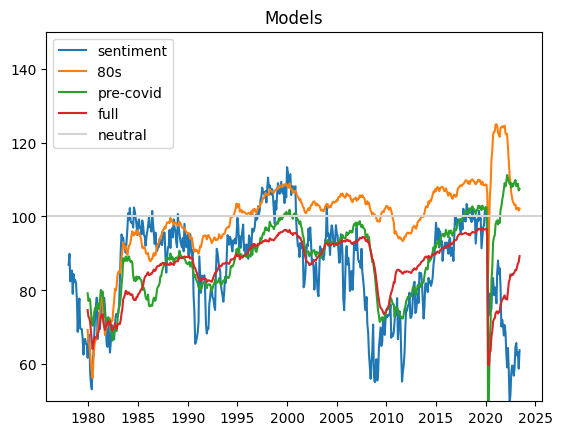

In [20]:
try_model(data,"sentiment ~ inflation + unemployment + unemployment_volatility + inflation_volatility")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     99.90
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.96e-50
Time:                        09:47:03   Log-Likelihood:                -442.15
No. Observations:                 144   AIC:                             900.3
Df Residuals:                     136   BIC:                             924.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Interc

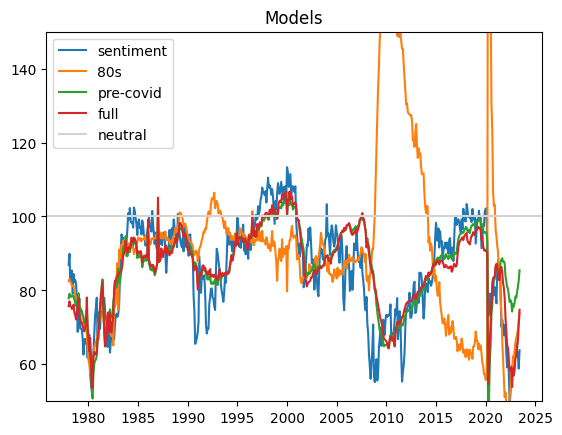

In [21]:
try_model(data, "sentiment ~ inflation * unemployment * rates")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     108.0
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           2.01e-49
Time:                        09:47:03   Log-Likelihood:                -447.18
No. Observations:                 144   AIC:                             908.4
Df Residuals:                     137   BIC:                             929.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

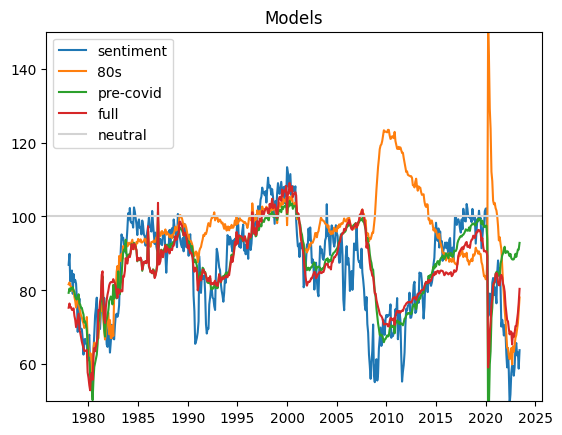

In [22]:
try_model(data, "sentiment ~ (inflation+unemployment+rates)**2")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     57.31
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.04e-35
Time:                        09:47:04   Log-Likelihood:                -229.28
No. Observations:                 121   AIC:                             586.6
Df Residuals:                      57   BIC:                             765.5
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     34.33
Date:                Wed, 09 Aug 2023   Prob (F-statistic):          3.09e-137
Time:                        09:47:04   Log-Likelihood:                -1645.6
No. Observations:                 523   AIC:                             3419.
Df Residuals:                     459   BIC:                             3692.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

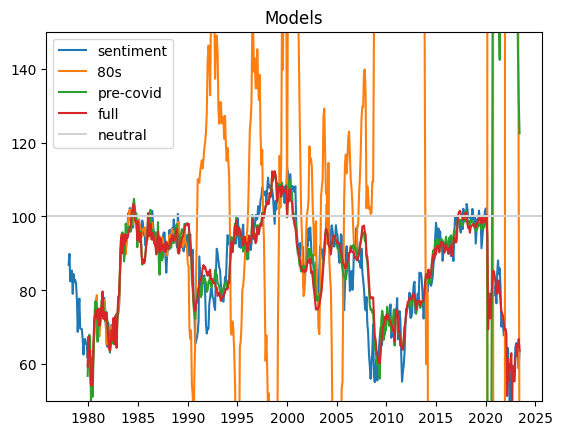

In [23]:
try_model(data, "sentiment ~ inflation * unemployment * rates * inflation_volatility * unemployment_volatility * rates_volatility")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     74.23
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           4.20e-51
Time:                        09:47:04   Log-Likelihood:                -310.72
No. Observations:                 121   AIC:                             665.4
Df Residuals:                      99   BIC:                             726.9
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

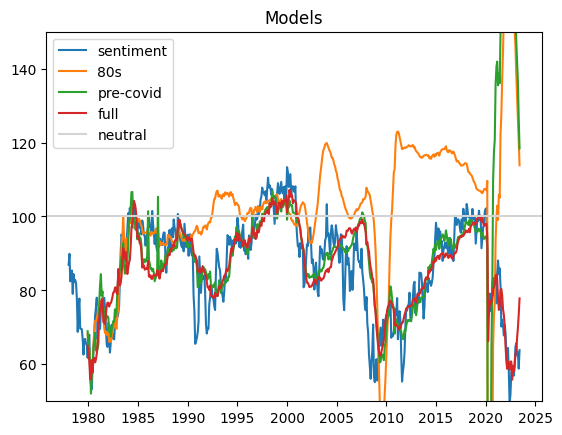

In [24]:
try_model(data, "sentiment ~ (inflation + unemployment + rates + inflation_volatility + unemployment_volatility + rates_volatility)**2")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     118.1
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           4.83e-54
Time:                        09:47:05   Log-Likelihood:                -332.23
No. Observations:                 121   AIC:                             686.5
Df Residuals:                     110   BIC:                             717.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

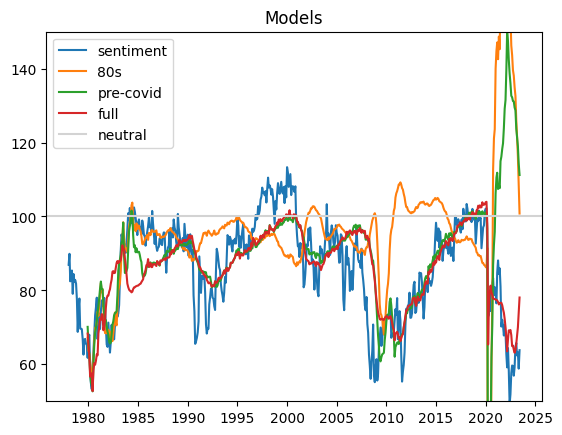

In [25]:
try_model(data, "sentiment ~ (inflation + unemployment + inflation_volatility + unemployment_volatility)**2")

In [26]:
model = smf.ols(formula="sentiment ~ inflation + unemployment + rates + unemployment_volatility + inflation_volatility + rates_volatility", data=data).fit()

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sentiment   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     107.9
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           8.90e-88
Time:                        09:47:05   Log-Likelihood:                -1888.7
No. Observations:                 523   AIC:                             3791.
Df Residuals:                     516   BIC:                             3821.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 110.2364      1.682     65.529      0.000     106.931     113.541
inflation                  -4.6117      0.299    -15.415      0.000      -5.199      -4.024
unemployment               -2.4933      0.268     -9.295      0.000      -3.020      -1.966
rates                       2.7294      0.184     14.852      0.000       2.368       3.090
unemployment_volatility    -1.9682      0.695     -2.831      0.005      -3.334      -0.602
inflation_volatility       -2.6675      1.044     -2.556      0.011      -4.718      -0.617
rates_volatility           -1.2537      0.852     -1.472      0.142      -2.927       0.420
==============================================================================
Omnibus:                       24.847   Durbin-Watson:                   0.287
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.062
Skew:                          -0.539   Prob(JB):                     1.33e-06
Kurtosis:                       3.286   Cond. No.                         42.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

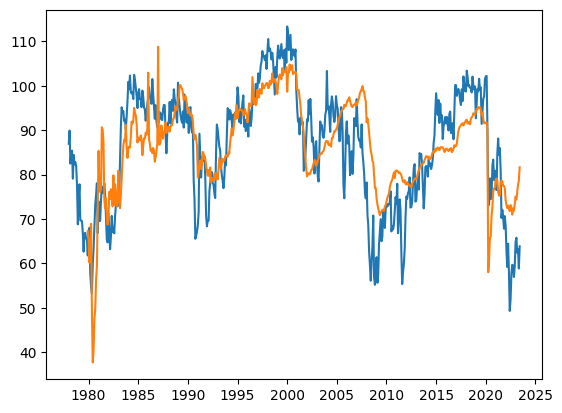

In [28]:
plt.plot(data.sentiment)
plt.plot(model.predict(data))
plt.show()

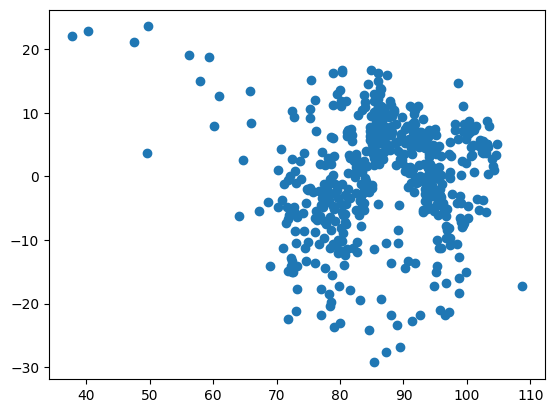

In [29]:
plt.scatter(x=model.fittedvalues, y=model.resid)

In [30]:
model = smf.ols(formula="np.log(sentiment) ~ inflation + unemployment + rates + unemployment_volatility + inflation_volatility + rates_volatility", data=data).fit()

In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(sentiment)   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     101.9
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           2.64e-84
Time:                        09:47:06   Log-Likelihood:                 402.13
No. Observations:                 523   AIC:                            -790.3
Df Residuals:                     516   BIC:                            -760.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.7237      0.021    224.235      0.000       4.682       4.765
inflation                  -0.0572      0.004    -15.277      0.000      -0.065      -0.050
unemployment               -0.0276      0.003     -8.231      0.000      -0.034      -0.021
rates                       0.0334      0.002     14.508      0.000       0.029       0.038
unemployment_volatility    -0.0245      0.009     -2.812      0.005      -0.042      -0.007
inflation_volatility       -0.0400      0.013     -3.059      0.002      -0.066      -0.014
rates_volatility           -0.0121      0.011     -1.133      0.258      -0.033       0.009
==============================================================================
Omnibus:                       51.246   Durbin-Watson:                   0.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.164
Skew:                          -0.753   Prob(JB):                     2.60e-15
Kurtosis:                       3.903   Cond. No.                         42.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

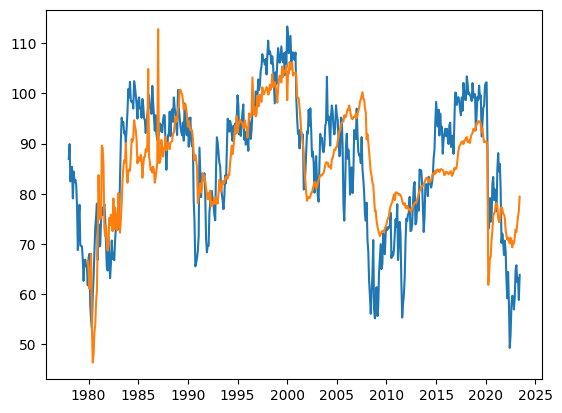

In [32]:
plt.plot(data.sentiment)
plt.plot(np.exp(model.predict(data)))

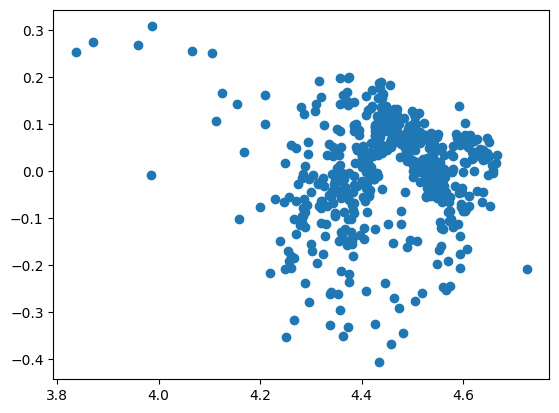

In [33]:
plt.scatter(x=model.fittedvalues, y=model.resid)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     118.1
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           4.83e-54
Time:                        09:47:06   Log-Likelihood:                -332.23
No. Observations:                 121   AIC:                             686.5
Df Residuals:                     110   BIC:                             717.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

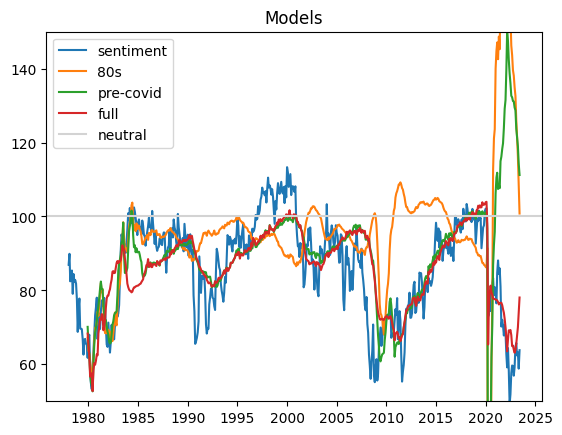

In [34]:
try_model(form="sentiment ~ (inflation + unemployment + inflation_volatility + unemployment_volatility)**2", data=data)

In [35]:
model = smf.ols(formula="sentiment ~ (inflation + unemployment + inflation_volatility + unemployment_volatility)**2", data=data).fit()

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sentiment   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     66.54
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           5.00e-86
Time:                        09:47:07   Log-Likelihood:                -1883.5
No. Observations:                 523   AIC:                             3789.
Df Residuals:                     512   BIC:                             3836.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      140.6869      3.998     35.187      0.000     132.832     148.542
inflation                                       -3.5317      1.502     -2.351      0.019      -6.483      -0.581
unemployment                                    -9.3907      0.644    -14.592      0.000     -10.655      -8.126
inflation_volatility                            -9.7400      5.744     -1.696      0.091     -21.024       1.544
unemployment_volatility                        -15.8014      2.741     -5.765      0.000     -21.186     -10.417
inflation:unemployment                           0.8765      0.242      3.623      0.000       0.401       1.352
inflation:inflation_volatility                  -2.2663      0.313     -7.233      0.000      -2.882      -1.651
inflation:unemployment_volatility               -0.5820      0.764     -0.762      0.446      -2.083       0.919
unemployment:inflation_volatility                2.5908      0.739      3.504      0.000       1.138       4.043
unemployment:unemployment_volatility             2.3365      0.299      7.818      0.000       1.749       2.924
inflation_volatility:unemployment_volatility    -1.3359      3.682     -0.363      0.717      -8.570       5.898
==============================================================================
Omnibus:                       47.362   Durbin-Watson:                   0.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.720
Skew:                          -0.667   Prob(JB):                     3.25e-15
Kurtosis:                       4.132   Cond. No.                         509.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

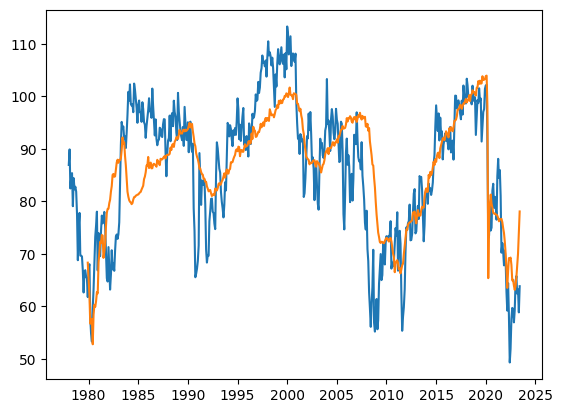

In [37]:
plt.plot(data.sentiment)
plt.plot(model.predict(data))

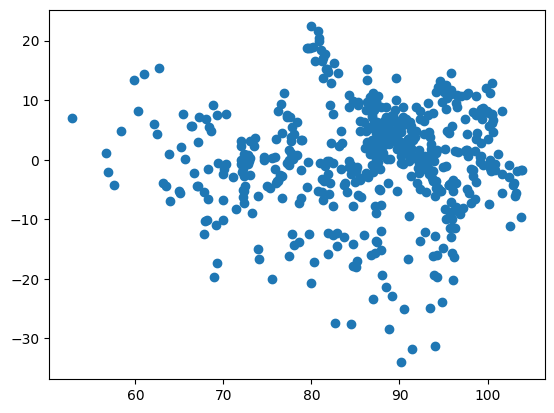

In [38]:
plt.scatter(x=model.fittedvalues, y=model.resid)

In [39]:
data['sentiment_move'] = data.sentiment - data.sentiment.rolling(12).mean()

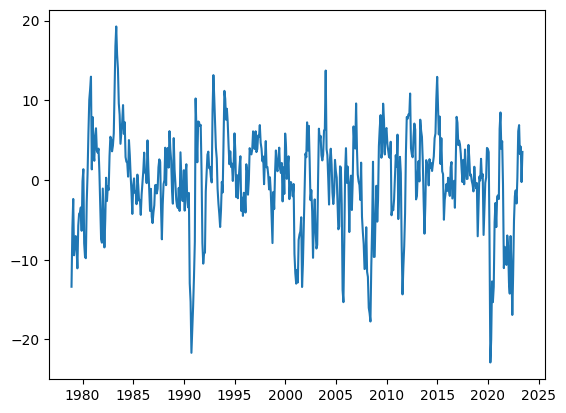

In [40]:
plt.plot(data.sentiment_move)

In [41]:
model = smf.ols(formula="sentiment_move ~ inflation * unemployment * rates", data=data).fit()

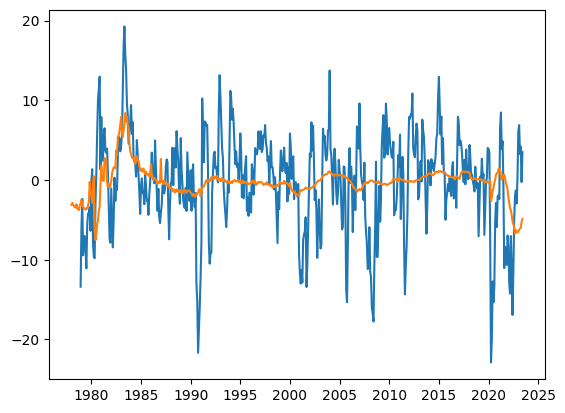

In [42]:
plt.plot(data.sentiment_move)
plt.plot(model.predict(data))

In [43]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sentiment_move   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     8.255
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.43e-09
Time:                        09:47:08   Log-Likelihood:                -1695.4
No. Observations:                 535   AIC:                             3407.
Df Residuals:                     527   BIC:                             3441.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        9.8752      2.937      3.363      0.001       4.106      15.644
inflation                       -3.1597      0.992     -3.185      0.002      -5.109      -1.211
unemployment                    -1.0250      0.407     -2.517      0.012      -1.825      -0.225
inflation:unemployment           0.2888      0.150      1.930      0.054      -0.005       0.583
rates                           -2.1435      0.535     -4.004      0.000      -3.195      -1.092
inflation:rates                  0.3594      0.107      3.366      0.001       0.150       0.569
unemployment:rates               0.3460      0.077      4.522      0.000       0.196       0.496
inflation:unemployment:rates    -0.0471      0.015     -3.155      0.002      -0.076      -0.018
==============================================================================
Omnibus:                       27.866   Durbin-Watson:                   0.450
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.000
Skew:                          -0.488   Prob(JB):                     4.14e-08
Kurtosis:                       3.757   Cond. No.                     4.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     72.32
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.13e-43
Time:                        09:47:08   Log-Likelihood:                -361.92
No. Observations:                 121   AIC:                             745.8
Df Residuals:                     110   BIC:                             776.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

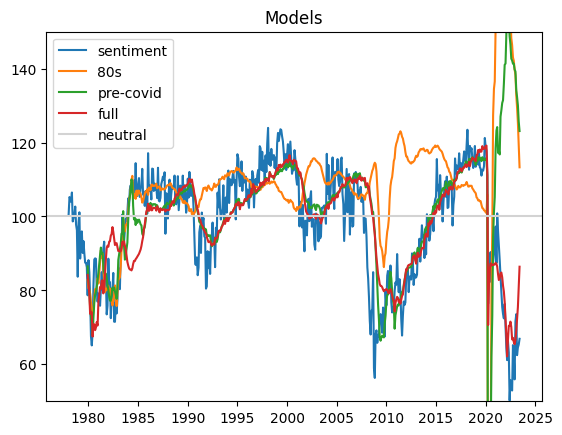

In [44]:
sentiment_by_region = pd.read_csv('consumer_sentiment_plus_region.csv', low_memory=False)

sentiment_by_region['DATE'] = pd.to_datetime(sentiment_by_region.YYYYMM, format="%Y%m")
sentiments = sentiment_by_region.groupby(['REGION', 'DATE']).ICC.mean()

regional_data = {}
for region in ['1', '2', '3', '4']:
    regional_data[region] = data.copy()
    regional_data[region]['sentiment'] = sentiments.loc[region]
try_model(form="sentiment ~ (inflation + unemployment + inflation_volatility + unemployment_volatility)**2",
         data=regional_data['4'])

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     137.5
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           2.74e-47
Time:                        09:47:08   Log-Likelihood:                -457.59
No. Observations:                 144   AIC:                             925.2
Df Residuals:                     139   BIC:                             940.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      120.1779      2.936    

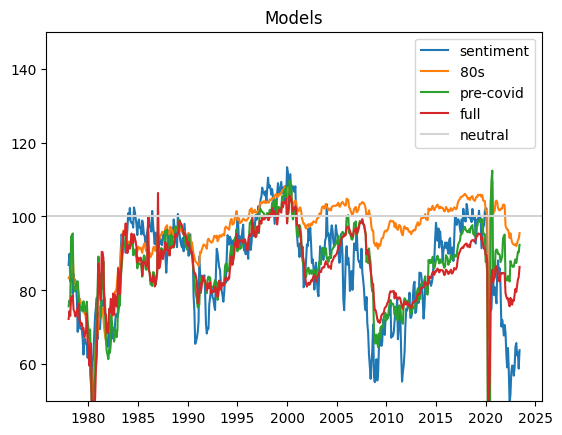

In [45]:
try_model(form="sentiment ~ inflation + unemployment + rates + gdp_growth", data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     95.70
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           4.64e-54
Time:                        09:47:09   Log-Likelihood:                -318.72
No. Observations:                 121   AIC:                             669.4
Df Residuals:                     105   BIC:                             714.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

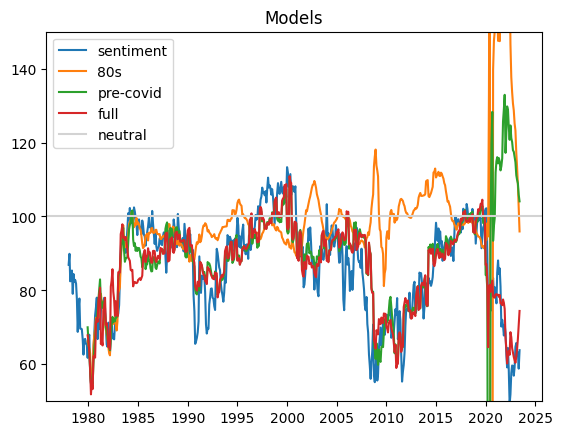

In [46]:
try_model(form="sentiment ~ (inflation + unemployment + gdp_growth + inflation_volatility + unemployment_volatility)**2", data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 09 Aug 2023   Prob (F-statistic):                nan
Time:                        09:47:09   Log-Likelihood:                 1807.0
No. Observations:                 121   AIC:                            -3372.
Df Residuals:                       0   BIC:                            -3034.
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
                                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

/home/nick/.virtualenvs/datasci/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/nick/.virtualenvs/datasci/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/nick/.virtualenvs/datasci/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     24.69
Date:                Wed, 09 Aug 2023   Prob (F-statistic):          4.95e-121
Time:                        09:47:10   Log-Likelihood:                -1359.7
No. Observations:                 482   AIC:                             2975.
Df Residuals:                     354   BIC:                             3510.
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

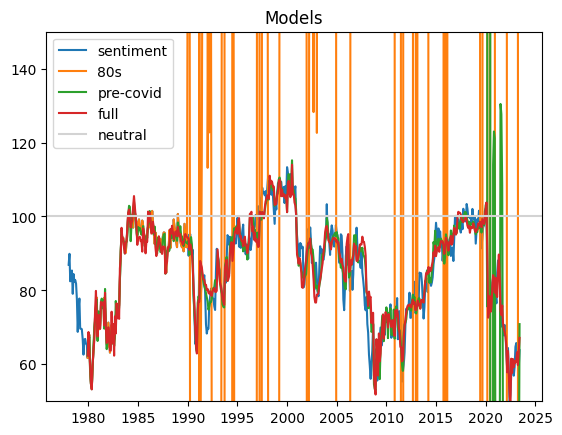

In [47]:
try_model(form="sentiment ~ inflation * unemployment * rates * inflation_volatility * unemployment_volatility * rates_volatility * gdp_growth", data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     100.8
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           3.25e-43
Time:                        09:47:10   Log-Likelihood:                -369.84
No. Observations:                 121   AIC:                             753.7
Df Residuals:                     114   BIC:                             773.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

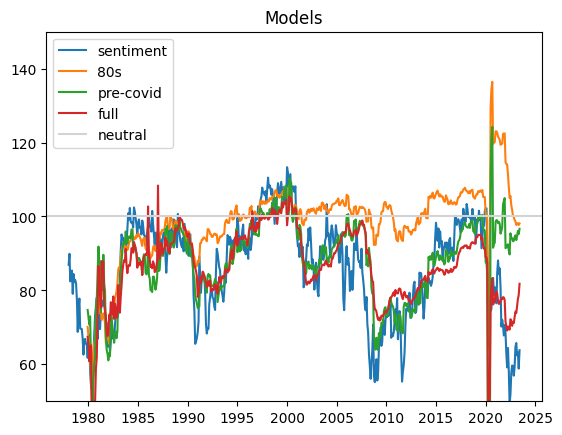

In [48]:
try_model(form="sentiment ~ inflation + unemployment + gdp_growth + inflation_volatility + unemployment_volatility + rates", data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     117.5
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           7.90e-51
Time:                        09:47:10   Log-Likelihood:                -345.72
No. Observations:                 121   AIC:                             709.4
Df Residuals:                     112   BIC:                             734.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

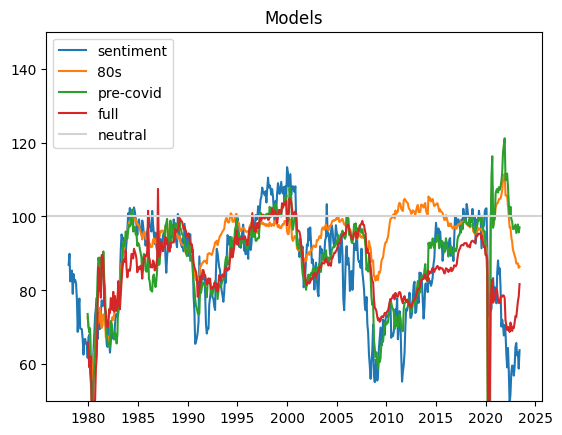

In [49]:
try_model(form="sentiment ~ inflation + unemployment + gdp_growth + inflation_volatility + unemployment_volatility + rates + inflation_24_month + unemployment_24_month", data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     130.6
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           3.99e-51
Time:                        09:47:11   Log-Likelihood:                -347.67
No. Observations:                 121   AIC:                             711.3
Df Residuals:                     113   BIC:                             733.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

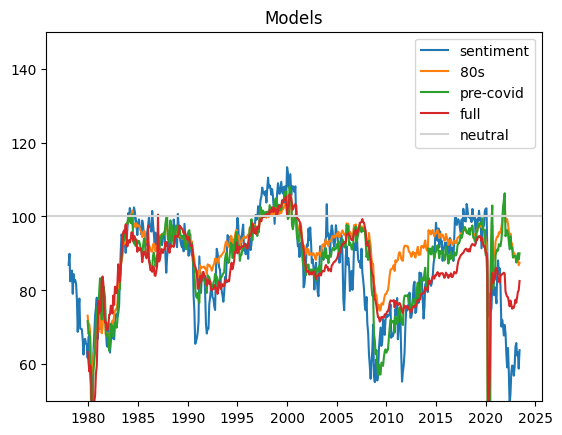

In [50]:
try_model(form="sentiment~inflation_24_month+unemployment_24_month+rates_24_month+gdp_growth_24_month+inflation+unemployment+gdp_growth+rates", data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     100.8
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           3.25e-43
Time:                        09:47:11   Log-Likelihood:                -369.84
No. Observations:                 121   AIC:                             753.7
Df Residuals:                     114   BIC:                             773.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

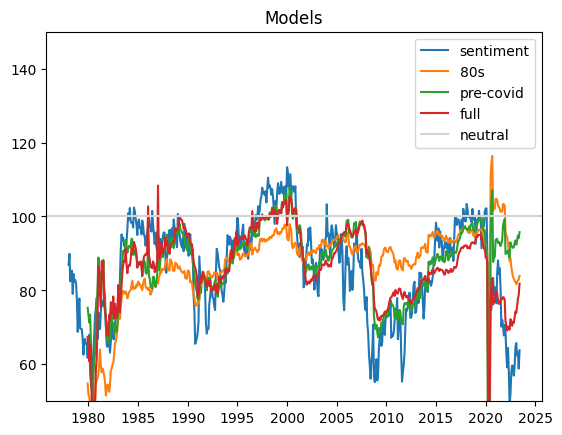

In [51]:
try_model(form="sentiment ~ norm(inflation) + norm(unemployment) + norm(gdp_growth) + norm(inflation_volatility) + norm(unemployment_volatility) + norm(rates)", data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     130.6
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           3.99e-51
Time:                        09:47:12   Log-Likelihood:                -347.67
No. Observations:                 121   AIC:                             711.3
Df Residuals:                     113   BIC:                             733.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercep

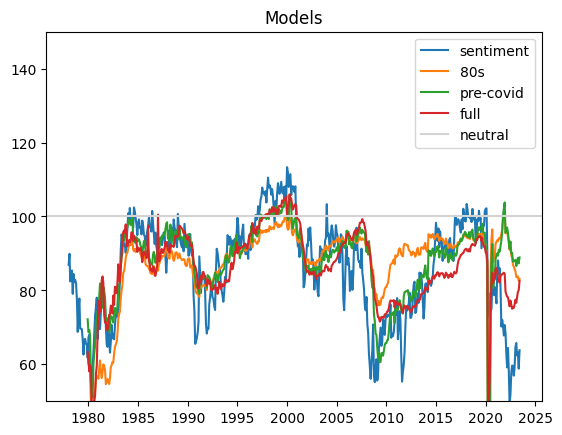

In [52]:
try_model(form="sentiment ~ norm(inflation) + norm(unemployment) + norm(rates) + norm(gdp_growth) + "+
          "norm(inflation_24_month) + norm(unemployment_24_month) + norm(rates_24_month) + norm(gdp_growth_24_month)",
          data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     123.1
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.77e-44
Time:                        09:47:12   Log-Likelihood:                -369.35
No. Observations:                 121   AIC:                             750.7
Df Residuals:                     115   BIC:                             767.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

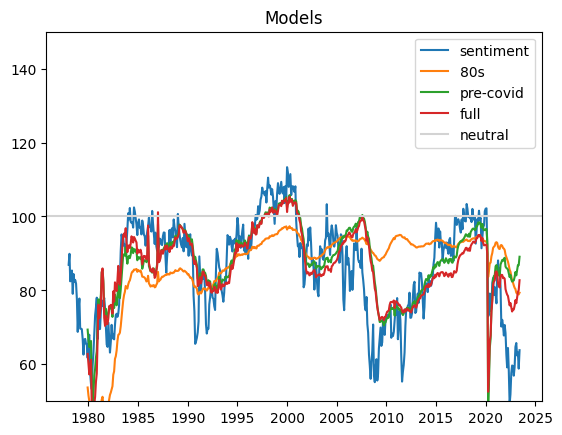

In [53]:
try_model(form="sentiment ~ norm(inflation) + norm(unemployment) + norm(rates) + "+
          "norm(inflation_24_month) + norm(rates_24_month) + norm(gdp_growth_24_month)",
          data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     137.5
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           2.74e-47
Time:                        09:47:12   Log-Likelihood:                -457.59
No. Observations:                 144   AIC:                             925.2
Df Residuals:                     139   BIC:                             940.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             84.9

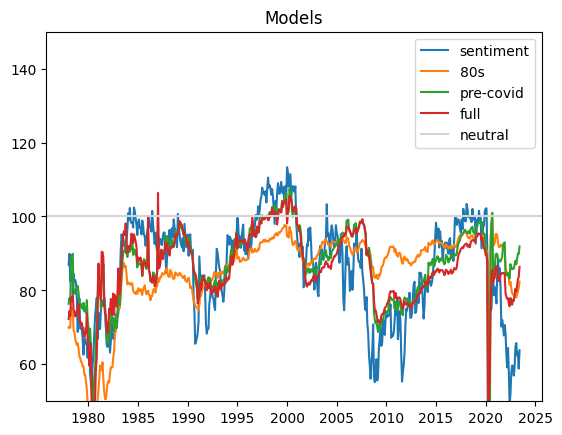

In [54]:
try_model(form="sentiment ~ norm(inflation) + norm(unemployment) + norm(rates) + norm(gdp_growth)",
          data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     183.3
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           4.84e-44
Time:                        09:47:13   Log-Likelihood:                -375.93
No. Observations:                 121   AIC:                             759.9
Df Residuals:                     117   BIC:                             771.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercep

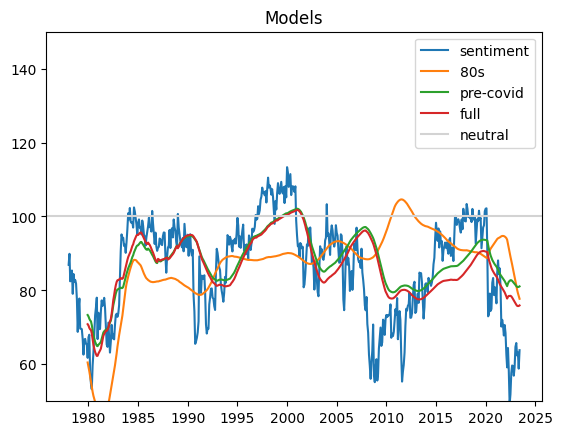

In [55]:
try_model(form="sentiment ~ norm(inflation_24_month) + norm(unemployment_24_month) + norm(rates_24_month) + norm(gdp_growth_24_month)",
          data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     126.0
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           2.18e-43
Time:                        09:47:13   Log-Likelihood:                -427.78
No. Observations:                 133   AIC:                             865.6
Df Residuals:                     128   BIC:                             880.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercep

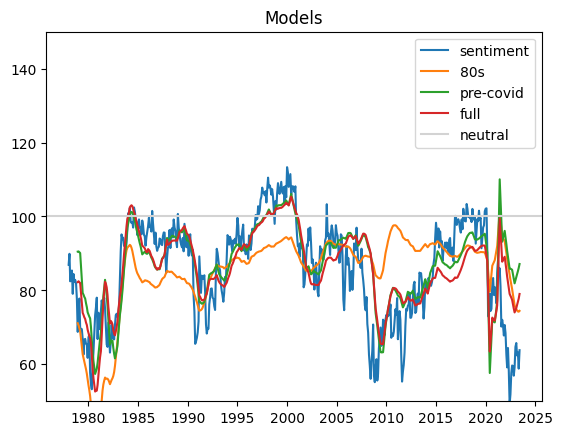

In [56]:
try_model(form="sentiment ~ norm(inflation_12_month) + norm(unemployment_12_month) + norm(rates_12_month) + norm(gdp_growth_12_month)",
          data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     134.0
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           8.18e-46
Time:                        09:47:14   Log-Likelihood:                -443.46
No. Observations:                 139   AIC:                             896.9
Df Residuals:                     134   BIC:                             911.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

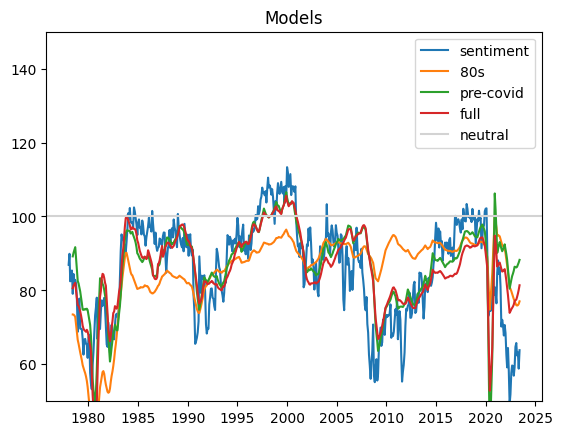

In [57]:
try_model(form="sentiment ~ norm(inflation.rolling(6).mean()) + norm(unemployment.rolling(6).mean()) + norm(rates.rolling(6).mean()) + norm(gdp_growth.rolling(6).mean())",
          data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     130.3
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.16e-44
Time:                        09:47:14   Log-Likelihood:                -435.53
No. Observations:                 136   AIC:                             881.1
Df Residuals:                     131   BIC:                             895.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

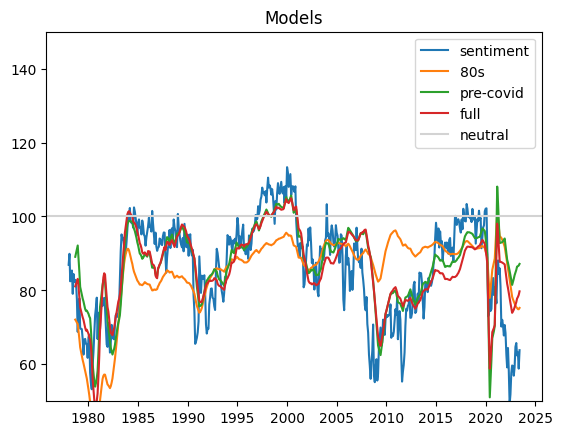

In [58]:
try_model(form="sentiment ~ norm(inflation.rolling(9).mean()) + norm(unemployment.rolling(9).mean()) + norm(rates.rolling(9).mean()) + norm(gdp_growth.rolling(9).mean())",
          data=data)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     105.4
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.12e-46
Time:                        09:47:15   Log-Likelihood:                -414.58
No. Observations:                 133   AIC:                             843.2
Df Residuals:                     126   BIC:                             863.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

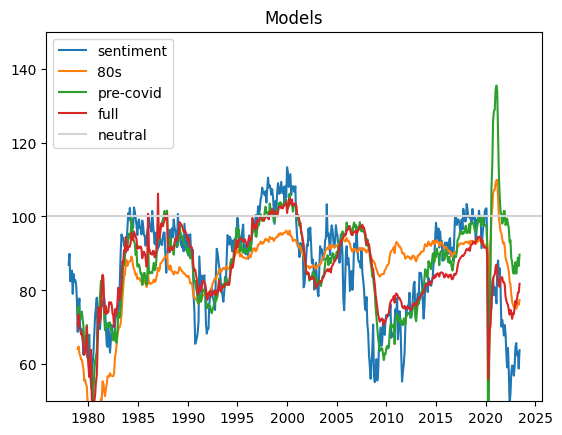

In [59]:
try_model(form="sentiment ~ norm(inflation.rolling(12).max()) + " +
              "norm(unemployment.rolling(12).max()) + norm(rates.rolling(12).max()) + "+
              "norm(inflation) + norm(unemployment) + norm(rates)",
          data=data)

In [285]:
data[['sentiment', 'current', 'future', 'inflation', 'unemployment', 'rates', 'gdp_growth', 'dow_change']].corr()

sentiment   current    future  inflation  unemployment  \
sentiment      1.000000  0.946372  0.974818  -0.364725     -0.427974   
current        0.946372  1.000000  0.850492  -0.294221     -0.484114   
future         0.974818  0.850492  1.000000  -0.390702     -0.362609   
inflation     -0.364725 -0.294221 -0.390702   1.000000      0.109287   
unemployment  -0.427974 -0.484114 -0.362609   0.109287      1.000000   
rates         -0.003426  0.022789 -0.021305   0.800071      0.125329   
gdp_growth     0.261925  0.237683  0.262366  -0.083199     -0.139030   
dow_change     0.132438  0.102334  0.144979  -0.035617      0.046479   

                 rates  gdp_growth  dow_change  
sentiment    -0.003426    0.261925    0.132438  
current       0.022789    0.237683    0.102334  
future       -0.021305    0.262366    0.144979  
inflation     0.800071   -0.083199   -0.035617  
unemployment  0.125329   -0.139030    0.046479  
rates         1.000000    0.037201   -0.016568  
gdp_growth    0.037201    1.000000    0.107125  
dow_change   -0.016568    0.107125    1.000000

In [284]:
data[['sentiment', 'inflation', 'unemployment', 'rates', 'gdp_growth', 'dow_change']][data.index < '2020'].corr()

sentiment  inflation  unemployment     rates  gdp_growth  \
sentiment      1.000000  -0.368871     -0.605283 -0.073138    0.437498   
inflation     -0.368871   1.000000      0.178373  0.823160   -0.137158   
unemployment  -0.605283   0.178373      1.000000  0.136470   -0.071479   
rates         -0.073138   0.823160      0.136470  1.000000    0.046115   
gdp_growth     0.437498  -0.137158     -0.071479  0.046115    1.000000   
dow_change     0.140740  -0.030905      0.040539 -0.018952    0.125112   

              dow_change  
sentiment       0.140740  
inflation      -0.030905  
unemployment    0.040539  
rates          -0.018952  
gdp_growth      0.125112  
dow_change      1.000000

In [69]:
data[['sentiment', 'inflation', 'unemployment', 'rates', 'gdp_growth']][data.index >= '2020'].corr()

sentiment  inflation  unemployment     rates  gdp_growth
sentiment      1.000000  -0.755591      0.320253 -0.406106    0.003380
inflation     -0.755591   1.000000     -0.619273  0.811658   -0.004610
unemployment   0.320253  -0.619273      1.000000 -0.470248   -0.317347
rates         -0.406106   0.811658     -0.470248  1.000000   -0.008664
gdp_growth     0.003380  -0.004610     -0.317347 -0.008664    1.000000

In [70]:
data[['sentiment', 'inflation', 'unemployment', 'rates', 'gdp_growth']][data.index < '2020'].describe()

sentiment   inflation  unemployment       rates  gdp_growth
count  504.000000  504.000000    504.000000  504.000000  504.000000
mean    87.209038    3.928995      6.188095    5.049484    0.006673
std     12.844743    2.686999      1.645349    4.295179    0.007266
min     53.254111    0.667614      3.500000    0.040000   -0.021831
25%     77.580921    2.343177      5.000000    1.287500    0.003532
50%     90.960250    3.003871      5.800000    5.025000    0.006950
75%     96.259400    4.684677      7.200000    7.617500    0.010084
max    113.337352   15.810582     10.800000   22.000000    0.038643

In [71]:
data[['sentiment', 'inflation', 'unemployment', 'rates', 'gdp_growth']][data.index >= '2020'].describe()

sentiment  inflation  unemployment      rates  gdp_growth
count   42.000000  42.000000     42.000000  42.000000   42.000000
mean    71.722321   3.784559      5.390476   1.244286    0.004814
std     12.478266   1.829289      2.690889   1.720661    0.032368
min     49.282608   1.517012      3.400000   0.050000   -0.084843
25%     62.473864   2.268993      3.600000   0.080000   -0.001446
50%     70.564954   2.924278      4.100000   0.090000    0.006470
75%     80.431345   5.626229      6.175000   2.145000    0.015428
max    102.200339   6.617223     14.700000   5.080000    0.078545

Model 80s
                            OLS Regression Results                            
Dep. Variable:        sentiment_logit   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     103.6
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           2.83e-46
Time:                        12:12:19   Log-Likelihood:                 61.603
No. Observations:                 133   AIC:                            -109.2
Df Residuals:                     126   BIC:                            -88.97
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

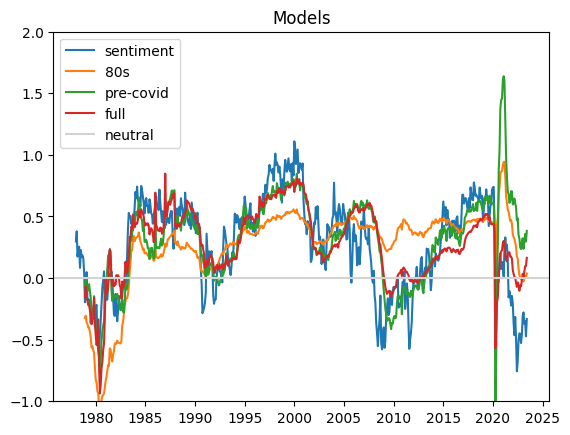

In [121]:
logit_params = {'predicted': data.sentiment_logit, 'y_min': -1, 'y_max': 2, 'neutral': 0}
try_model(form="sentiment_logit ~ norm(inflation.rolling(12).max()) + " +
              "norm(unemployment.rolling(12).max()) + norm(rates.rolling(12).max()) + "+
              "norm(inflation) + norm(unemployment) + norm(rates)",
          data=data,
          **logit_params)

Model 80s
                            OLS Regression Results                            
Dep. Variable:        sentiment_logit   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     134.3
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           9.84e-47
Time:                        12:13:33   Log-Likelihood:                 57.703
No. Observations:                 144   AIC:                            -105.4
Df Residuals:                     139   BIC:                            -90.56
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2

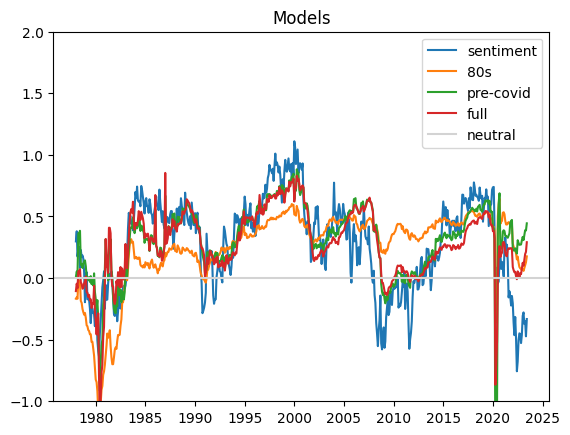

In [123]:
try_model(form="sentiment_logit ~ norm(inflation) + norm(unemployment) + norm(rates) + norm(gdp_growth)",
          data=data, **logit_params)

In [165]:
model_logit = try_model(form="sentiment_logit ~ norm(inflation) + norm(unemployment) + norm(gdp_growth)",
                  data=data, **logit_params)

Model 80s
                            OLS Regression Results                            
Dep. Variable:        sentiment_logit   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     179.1
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.00e-47
Time:                        17:29:06   Log-Likelihood:                 57.294
No. Observations:                 144   AIC:                            -106.6
Df Residuals:                     140   BIC:                            -94.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2

In [166]:
plt.scatter(x=model_logit.fittedvalues, y=model_logit.resid)

In [172]:
logit_params

{'predicted': DATE
 1978-01-01    0.297562
 1978-02-01    0.379831
 1978-03-01    0.174702
 1978-04-01    0.233441
 1978-05-01    0.254477
                 ...   
 2023-02-01   -0.278881
 2023-03-01   -0.371733
 2023-04-01   -0.348934
 2023-05-01   -0.472762
 2023-06-01   -0.332372
 Name: sentiment_logit, Length: 546, dtype: float64,
 'y_min': -1,
 'y_max': 2,
 'neutral': 0}

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     183.4
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           2.67e-48
Time:                        17:33:28   Log-Likelihood:                -457.97
No. Observations:                 144   AIC:                             923.9
Df Residuals:                     140   BIC:                             935.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             84.9

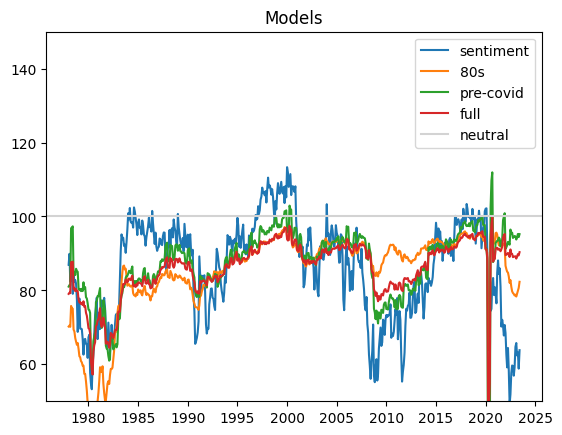

In [177]:
model = try_model(form="sentiment ~ norm(inflation) + norm(unemployment) + norm(gdp_growth)",
                  data=data)

In [169]:
plt.scatter(x=model.fittedvalues, y=model.resid)

In [190]:
plt.plot(data.sentiment)
plt.plot(expit(model_logit.fittedvalues)*2*100*5/6.7558 +2)
plt.plot(model.fittedvalues)

In [195]:
model = try_model(form="future ~ norm(inflation.rolling(6).mean()) + norm(unemployment.rolling(6).mean()) + norm(gdp_growth.rolling(6).mean())",
                  data=data, predicted=data.future, y_min=25, y_max=125)

Model 80s
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     125.6
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           6.86e-39
Time:                        17:49:43   Log-Likelihood:                -475.93
No. Observations:                 139   AIC:                             959.9
Df Residuals:                     135   BIC:                             971.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

Model 80s
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     52.71
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           6.85e-37
Time:                        18:30:28   Log-Likelihood:                -461.22
No. Observations:                 137   AIC:                             940.4
Df Residuals:                     128   BIC:                             966.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

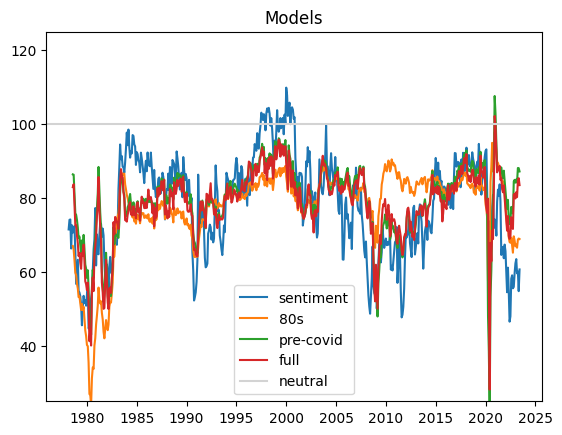

In [286]:
model = try_model(form="future ~ norm(inflation.rolling(6).mean()) + norm(unemployment.rolling(6).mean()) + "+
                  "norm(gdp_growth.rolling(6).mean()) + norm(dow_change.rolling(6).mean()) + "+
                  "norm(inflation) + norm(unemployment) + norm(gdp_growth) + norm(dow_change)",
                  data=data, predicted=data.future, y_min=25, y_max=125)

Model 80s
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     92.98
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           3.20e-53
Time:                        18:33:33   Log-Likelihood:                -415.43
No. Observations:                 137   AIC:                             852.9
Df Residuals:                     126   BIC:                             885.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

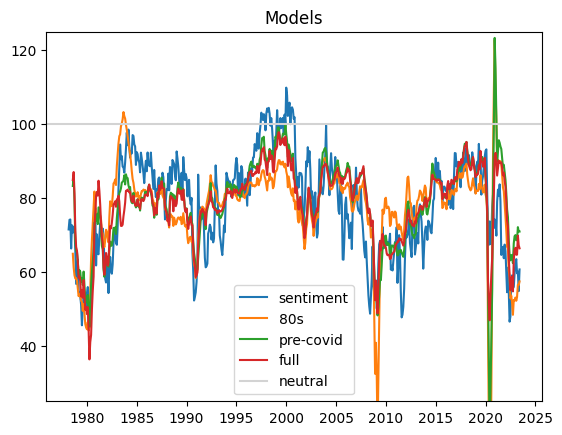

In [288]:
model = try_model(form="future ~ (norm(unemployment.rolling(6).mean()) + "+
                  "norm(gdp_growth.rolling(6).mean()) + norm(dow_change.rolling(6).mean()) + "+
                  "norm(inflation))**2",
                  data=data, predicted=data.future, y_min=25, y_max=125)

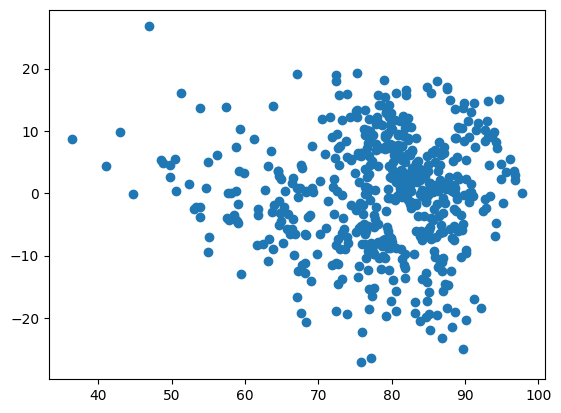

In [289]:
plt.scatter(x=model.fittedvalues, y=model.resid)